# Import Tweets Data 


1.   Import Tweets from sntwitter API (https://github.com/JustAnotherArchivist/snscrape)

2.   Clean up data - Remove special characters, emojis, memes in each tweets

In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt
import csv
import datetime as dt
import snscrape.modules.twitter as sntwitter

In [2]:
tweets = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i, tweet in enumerate(
    sntwitter.TwitterSearchScraper(
        '#Black Lives Matter since:2022-01-01 lang:en'
    ).get_items()
):
    tweets.append([tweet.date, tweet.rawContent])

In [3]:
tweets = pd.DataFrame(tweets, columns=['Date', 'Tweets'])
tweets

,Date,Tweets
0,2023-01-29 17:19:22+00:00,Obamas Call For Police Reform After Release of...
1,2023-01-29 17:19:22+00:00,Obamas Call For Police Reform After Release of...
2,2023-01-29 17:19:22+00:00,Obamas Call For Police Reform After Release of...
3,2023-01-29 12:17:11+00:00,@CalltoActivism #Black Lives Matter
4,2023-01-29 00:48:51+00:00,@hodgetwins Well you can always count on our c...
...,...,...
933,2022-01-03 00:15:50+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
934,2022-01-02 08:09:47+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
935,2022-01-02 00:06:53+00:00,Dedicated to Desmond Tutu | Humans - via @pens...
936,2022-01-01 13:04:11+00:00,"Here, Glenn Loury addresses Black Lives Matter..."


In [4]:
data=tweets
cdata=pd.DataFrame(columns=['Date','Tweets'])
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    #the following cleaning steps are not the standard. You may generate your own ways of cleaning.
    my_new_string = re.sub('#\w+', '', stre) #remove the hashtags
    my_new_string = re.sub('http\S+', '', my_new_string) #remove the links
    my_new_string = re.sub('\n', '', my_new_string) #remove \n
    cdata.sort_index()
    cdata.at[index,'Date']=row["Date"]
    cdata.at[index,'Tweets']=my_new_string
    index=index+1
tweets=cdata
tweets['Date'] = tweets['Date'].astype('datetime64[ns]')
tweets["Date"]=tweets["Date"].dt.date

In [5]:
tweets.head()

,Date,Tweets
0,2023-01-29,Obamas Call For Police Reform After Release of...
1,2023-01-29,Obamas Call For Police Reform After Release of...
2,2023-01-29,Obamas Call For Police Reform After Release of...
3,2023-01-29,@CalltoActivism Lives Matter
4,2023-01-29,@hodgetwins Well you can always count on our c...


# Sentiment Analysis for Tweets

Sentiment Analysis is a process of ‘computationally’ evaluating whether a piece of text is positive, negative or neutral. In our case, conducting sentiment analysis on tweets help determine the public's moods towards BLM(Black Lives Matter) topic.
1.   **VADER (Valence Aware Dictionary and Entiment Reasoner)** https://github.com/cjhutto/vaderSentiment

```
"VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed
in social media. A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled
according to their semantic orientation aseither positive or negative. VADER not only tells about the Positivity
and Negativity score but also tells us about how positive or negative a sentiment is." (GreeksforGreeks)
```
2.   **Reference**
 
  Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [6]:
import pyspark as spark
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,udf,monotonically_increasing_id,unix_timestamp,round,avg
import re
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

23/01/30 12:17:23 WARN Utils: Your hostname, Steven-Hes-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 10.200.111.249 instead (on interface en0)
23/01/30 12:17:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/30 12:17:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
FullDataTw=sql.createDataFrame(tweets)
FullDataTw = FullDataTw.dropna()
FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
 #setting column names of Twitter dataset
CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])  #withColumn function would generate the result with a new column name
CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
CleanDF.show(120)
CleanDF.toPandas().to_csv('sen.csv',index=False)

+----------+--------------------+-----+-----+-----+-------+
| Date_Time|              Tweets|p_neg|p_neu|p_pos| p_comp|
+----------+--------------------+-----+-----+-----+-------+
|2023-01-29|Obamas Call For P...|  0.0|0.942|0.058| 0.0258|
|2023-01-29|Obamas Call For P...|  0.0|0.942|0.058| 0.0258|
|2023-01-29|Obamas Call For P...|  0.0|0.942|0.058| 0.0258|
|2023-01-29|@CalltoActivism  ...|  0.0|0.645|0.355| 0.0258|
|2023-01-29|@hodgetwins Well ...|  0.0|0.882|0.118|  0.296|
|2023-01-28|@JFlippo1327 Oh I...|  0.0|0.864|0.136| 0.0258|
|2023-01-28|Someone tell blac...|  0.0|0.851|0.149| 0.2732|
|2023-01-27|10 -   Matter whe...|0.242|0.515|0.243|-0.2439|
|2023-01-26|Those  policeman ...|  0.0|0.857|0.143| 0.3612|
|2023-01-26|In New York City ...|0.164|0.707|0.128|-0.5166|
|2023-01-25|Black Lives Matte...|  0.0| 0.82| 0.18| 0.0258|
|2023-01-24|Excited to share ...|  0.0|0.678|0.322| 0.5719|
|2023-01-23|+++ NEW DESIGNS +...|  0.0|  1.0|  0.0|    0.0|
|2023-01-22|  Lives Matter wa...|0.153|0

 **Categorize Sentiments**
Once getting the compound sentiment score for each Tweets, we put them into categories. 


  $$Negative \ Sentiment : -0.9<P_{comp}\leq -0.05$$
   
  $$Positive\  Sentiment: 0.05\leq P_{comp}<0.9$$

  $$Neutral \ Sentiment:  -0.05<P_{comp}<0.05 $$

  $$Extremely\ Negative \ Sentiment:  P_{comp}\leq -0.9 $$

  $$Extremely\ Postive \ Sentiment:  P_{comp}\geq 0.9 $$

In [8]:
tw=pd.read_csv("sen.csv")
tw["length"]=""
i=0
# iterate through the csv file 
for val in tw["Tweets"]: 
  val = str(val) 
  tokens = val.split() 
  tw["length"][i]=len(tokens)
  i=i+1
tw=tw.drop(columns=["p_neg","p_neu","p_pos"])

In [9]:
tw.loc[(tw['p_comp']>-0.05)&(tw['p_comp']<0.05),'sentiment']="neutral"
tw.loc[(tw['p_comp']>=0.05)&(tw['p_comp']<0.9),'sentiment']='positive'
tw.loc[(tw['p_comp']<=-0.05)&(tw['p_comp']>-0.9),'sentiment']='negative'
tw.loc[tw['p_comp']<=-0.9,'sentiment']='extremely negative'
tw.loc[tw['p_comp']>=0.9,'sentiment']='extremely positive'
tw

,Date_Time,Tweets,p_comp,length,sentiment
0,2023-01-29,Obamas Call For Police Reform After Release of...,0.0258,19,neutral
1,2023-01-29,Obamas Call For Police Reform After Release of...,0.0258,19,neutral
2,2023-01-29,Obamas Call For Police Reform After Release of...,0.0258,19,neutral
3,2023-01-29,@CalltoActivism Lives Matter,0.0258,3,neutral
4,2023-01-29,@hodgetwins Well you can always count on our c...,0.2960,21,positive
...,...,...,...,...,...
933,2022-01-03,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
934,2022-01-02,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
935,2022-01-02,Dedicated to Desmond Tutu | Humans - via @pens...,0.4588,9,positive
936,2022-01-01,"Here, Glenn Loury addresses Black Lives Matter...",-0.9231,30,extremely negative


23/01/30 18:30:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 145451 ms exceeds timeout 120000 ms
23/01/30 18:30:04 WARN SparkContext: Killing executors is not supported by current scheduler.


# Exercise2

#### Crawl data from twitter with another topic and do sentiment analysis on the data, after you get the results, try to use graphs to visualize the sentiment analysis results (any type of graph that could satisfy your purpose)

In [11]:
tweets = []
LIMIT = 0xFFFF
for i, tweet in enumerate(
    sntwitter.TwitterSearchScraper(
        'Elon Musk lang:en'
    ).get_items()
):
    if i >= LIMIT:
        break
    tweets.append([tweet.date, tweet.rawContent])

In [12]:
tweets = pd.DataFrame(tweets, columns=["Date", "Content"])
tweets

,Date,Content
0,2023-01-31 00:43:46+00:00,Fidelity has marked down the value of its Twit...
1,2023-01-31 00:43:45+00:00,@lafitnessstairs @FoxNews @Tesla @elonmusk Meh...
2,2023-01-31 00:43:45+00:00,"Lol, just had an email from the ""Elon Musk Tea..."
3,2023-01-31 00:43:45+00:00,@elonmusk @TeslaHype Keep it up and you’ll end...
4,2023-01-31 00:43:45+00:00,@andst7 @ellagirwin This is so stupid. There's...
...,...,...
4090,2023-01-30 23:48:30+00:00,"@Cronos_ChainNFT ""Mission Control, this is Hou..."
4091,2023-01-30 23:48:28+00:00,@julianhosp @MrBeast @elonmusk I’m curious to ...
4092,2023-01-30 23:48:26+00:00,Elon Musk is self reflecting here…especially n...
4093,2023-01-30 23:48:24+00:00,Local Hen Surpasses Elon Musk In Net Worth htt...


In [13]:
compound_sentiment = []
for content in tweets.Content:
    sentiment_dict = analyser.polarity_scores(content)
    compound_sentiment.append(sentiment_dict["compound"])
compound_sentiment

[0.34,
 0.7889,
 0.8674,
 0.3612,
 -0.656,
 -0.3818,
 0.0,
 0.1901,
 0.0,
 0.5267,
 0.2973,
 0.5994,
 0.2263,
 0.3237,
 0.4215,
 0.9182,
 -0.5859,
 0.8957,
 0.0,
 -0.6077,
 0.6884,
 0.0,
 0.0,
 0.8658,
 -0.5076,
 -0.5267,
 0.2023,
 -0.8232,
 0.659,
 0.0,
 -0.4588,
 0.3313,
 0.6858,
 0.0,
 0.0,
 0.7346,
 -0.5994,
 0.0,
 0.7906,
 0.3612,
 0.3197,
 0.4215,
 0.1511,
 -0.7003,
 0.0,
 0.0,
 0.0,
 0.8372,
 -0.3182,
 0.7906,
 0.0,
 0.0,
 0.0,
 0.5093,
 0.0992,
 0.4767,
 0.6808,
 0.0,
 0.4019,
 0.0,
 0.2263,
 0.3182,
 -0.5423,
 -0.0852,
 0.0,
 0.2481,
 0.5994,
 -0.1531,
 0.3818,
 0.4939,
 0.0,
 0.4927,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.765,
 0.8856,
 0.4667,
 0.4404,
 0.0,
 0.636,
 -0.6369,
 0.4588,
 0.5267,
 0.2023,
 -0.5267,
 -0.2732,
 0.7351,
 -0.296,
 0.5789,
 0.4767,
 -0.7703,
 0.4753,
 0.7184,
 0.5719,
 0.0,
 0.0,
 -0.34,
 -0.4767,
 0.7672,
 0.4199,
 0.0,
 0.0,
 0.3182,
 0.5106,
 0.4019,
 -0.3818,
 0.0,
 -0.2584,
 0.4404,
 -0.128,
 0.3612,
 0.7717,
 0.4588,
 0.7643,
 0.2732,
 -0.871,
 0.0,

In [14]:
tweets["Sentiment"] = compound_sentiment

In [15]:
import matplotlib.pyplot as plt

<AxesSubplot: >

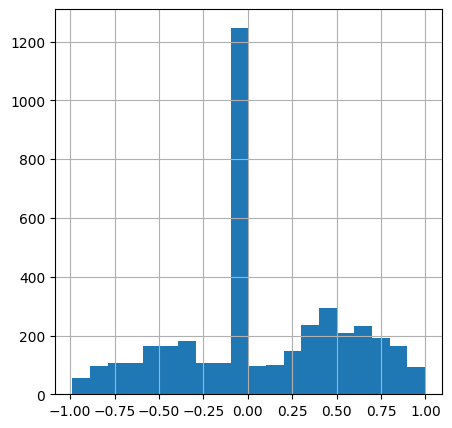

In [17]:
plt.figure(figsize=(5,5))
tweets["Sentiment"].hist(bins=20)

This histogram indicates that the tweets on twitter mentioning Elon Musk are,
in general,
half positive and half negative,
with most of them being neutral,
and slightly more of them being positive than negative.